## Splines
Fitting Natural Splines to data.

#### Preliminaries

In [1]:
## load some packages
import matplotlib.pyplot as plt
from scipy import sparse
import numpy as np

### config
X_MIN = 0
X_MAX = 1
N = 11
X = np.linspace(X_MIN, X_MAX, N)
Y = np.sin(2*np.pi * X)

#### Visualize
Plot the points we'll try to interpolate.

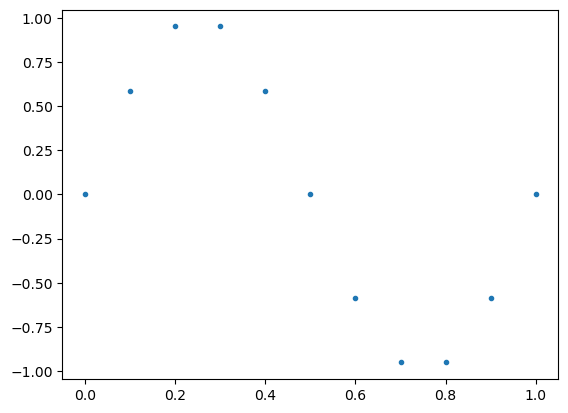

In [2]:
plt.plot(X, Y, '.')

#### Linear Spline
AKA: Fit a line between all the points

We have $n$ lines for $n+1$ data points. Each line $i$ can be written as
$$
y = a_i x + b_i
$$
where
$$
y_i = a_i x_i + b_i
$$
and
$$
y_{i+1} = a_i x_{i+1} + b_i.
$$

We write this as a matrix equation
$$
\begin{pmatrix}
    x_1 & 1 & 0 & 0 & \dots & 0 & 0 & 0 & 0 \\
    x_2 & 1 & 0 & 0 & \dots & 0 & 0 & 0 & 0 \\
    0 & 0 & x_2 & 1 & \dots & 0 & 0 & 0 & 0 \\
    0 & 0 & x_3 & 1 & \dots & 0 & 0 & 0 & 0 \\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots \\
    0 & 0 & 0 & 0 & \dots & x_{n-1} & 1 & 0 & 0 \\
    0 & 0 & 0 & 0 & \dots & x_n & 1 & 0 & 0 \\
    0 & 0 & 0 & 0 & \dots & 0 & 0 & x_n & 1 \\
    0 & 0 & 0 & 0 & \dots & 0 & 0 & x_{n+1} & 1 \\
\end{pmatrix}
\begin{pmatrix}
    a_1 \\ b_1 \\ a_2 \\ b_2 \\ \vdots \\ a_{n-1} \\ b_{n-1} \\ a_n \\ b_n
\end{pmatrix}
=
\begin{pmatrix}
    y_1 \\ y_2 \\ y_2 \\ y_3 \\ \vdots \\ y_{n-1} \\ y_n \\ y_n \\ y_{n+1}
\end{pmatrix}
$$

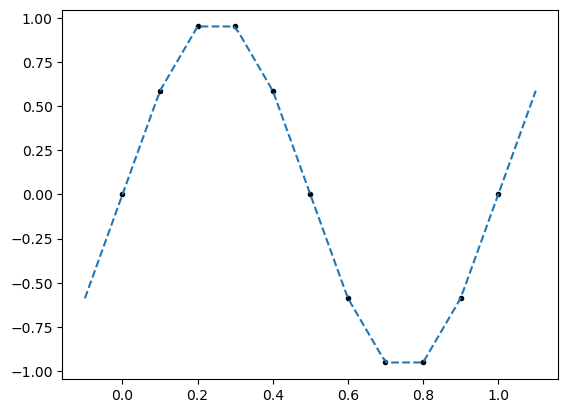

In [3]:
def get_linear_spline(x, y):
    '''
    Solve for the interpolating linear spline for a set of points.
    '''
    # setuo
    n = len(x)
    if (np.diff(x) < 0).any():  # we interpolate between neaby points, needs to be sorted
        idxs = np.argsort(x)
        x = x[idxs]
        y = y[idxs]
    assert (x[:-1] != x[1:]).all()

    ## build constraint matrix. In each concat the:
    # first row enforces P_i(x_i) = y_i
    # second row enforces P_i(x_{i+1}) = y_{i+1}
    data = np.concatenate([
            np.ravel([x[:-1], np.ones(n-1)], 'F'),  # create array that goes x_1, 1, x_2, 1, ...
            np.ravel([x[1:], np.ones(n-1)], 'F'),  # create array that goes x_2, 1, x_3, 1, ...
        ])
    row = np.concatenate([
            np.repeat(np.arange(n-1), 2),
            n-1 + np.repeat(np.arange(n-1), 2),
        ])
    col = np.concatenate([
            np.arange(2*(n-1)),
            np.arange(2*(n-1)),
        ])
    A = sparse.csr_array((data, (row, col)), shape=(2*(n-1), 2*(n-1)))
    b = np.concatenate([y[:-1], y[1:]])

    # solve
    sol = sparse.linalg.spsolve(A, b)
    a = sol[::2]  # slopes
    b = sol[1::2]  # intercepts

    # create interpolating function and return
    def linear_spline(X):
        '''
        The function representing the interpolating linear spline at an X
        '''
        idx = np.minimum(np.maximum(np.searchsorted(x, X, 'right')-1, 0), n-2)  # figure out which spline to use to connect the points

        return a[idx]*X + b[idx]
    
    return linear_spline

# grid we want to calculate values at
xrange = X_MAX - X_MIN
x_grid = np.linspace(X_MIN-xrange*0.1, X_MAX+xrange*0.1, 101)

# plot it
plt.plot(X, Y, 'k.')
plt.plot(x_grid, get_linear_spline(X, Y)(x_grid), '--')

#### Quadratic Spline
AKA: Fit a parabola between each set of two points such that the slopes match where two parabolas meet

We have $n$ parabolas for $n+1$ data points. Each parabola can be written as
$$
y = a_i x^2 + b_i x + c_i
$$
such that
$$
y_i = a_i x_i^2 + b_i x_i + c_i,
$$
$$
y_{i+1} = a_i x_{i+1}^2 + b_i x_{i+1} + c_i,
$$
and
$$
2 a_i x_{i+1} + b_i = 2 a_{i+1} x_{i+1} + b_{i+1}.
$$
We'll also enforce $a_1 = 0$ to create a solveable system.

This becomes the matrix equation
$$
\begin{pmatrix}
x_1^2 & x_1 & 1 & 0 & 0 & 0 & \dots \\
x_2^2 & x_2 & 1 & 0 & 0 & 0 & \dots \\
0 & 0 & 0 & x_2^2 & x_2 & 1 & \dots \\
0 & 0 & 0 & x_3^2 & x_3 & 1 & \dots \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots \\
1 & 0 & 0 & 0 & 0 & 0 & \dots \\
2 x_2 & 1 & 0 & -2 x_2 & -1 & 0 & \dots \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix}
\begin{pmatrix}
a_1 \\ b_1 \\ c_1 \\ a_2 \\ b_2 \\ c_2 \\ \vdots
\end{pmatrix}
=
\begin{pmatrix}
y_1 \\ y_2 \\ y_2 \\ y_3 \\ \vdots \\ 0 \\ 0 \\ \vdots
\end{pmatrix}
$$

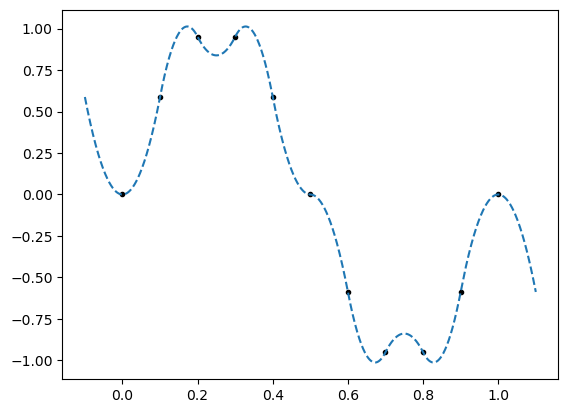

In [4]:
def get_quadratic_spline(x, y):
    '''
    Solve for the interpolating quadratic spline for a set of points.
    '''
    # setuo
    n = len(x)
    if (np.diff(x) < 0).any():  # we interpolate between neaby points, needs to be sorted
        idxs = np.argsort(x)
        x = x[idxs]
        y = y[idxs]
    assert (x[:-1] != x[1:]).all()

    ## build constraint matrix. In each concat the:
    # first row enforces P_i(x_i) = y_i
    # second row enforces P_i(x_{i+1}) = y_{i+1}
    # third row enforces P_i'(x_{i+1}) = P_{i+1}'(x_{i+1})
    data = np.concatenate([
            np.ravel([x[:-1]**2, x[:-1], np.ones(n-1)], 'F'),  # create array that goes x_1^2, x_1, 1, x_2^2, x_2, 1, ...
            np.ravel([x[1:]**2, x[1:], np.ones(n-1)], 'F'),  # create array that goes x_2^2, x_2, 1, x_3^2, x_3, 1, ...
            np.ravel([2*x[:-1], np.ones(n-1), -2*x[:-1], -np.ones(n-1)], 'F')[2:],  # create array that goes 2*x_1, 1, -2*x_1, -1, 2*x_2, 1, -2*x_2, -1 and skips -2*x_n, -1
        ])
    row = np.concatenate([
            np.repeat(np.arange(n-1), 3),
            n-1 + np.repeat(np.arange(n-1), 3),
            2*(n-1) + np.repeat(np.arange(n-1), 4)[2:],
        ])
    col = np.concatenate([
            np.arange(3*(n-1)),
            np.arange(3*(n-1)),
            np.tile(np.arange(3*(n-1)).reshape(3, -1, order='F')[:2], (2, 1)).ravel('F')[:-2],  # goes 0, 1, 0, 1, 3, 4, 3, 4... skipping the last two
        ])
    A = sparse.csr_array((data, (row, col)), shape=(3*(n-1), 3*(n-1)))
    b = np.concatenate([y[:-1], y[1:], np.zeros(n-1)])

    # solve
    sol = sparse.linalg.spsolve(A, b)
    a = sol[::3]  # quadratic mulitplier
    b = sol[1::3]  # linear multipler
    c = sol[2::3]  # intercept

    # create interpolating function and return
    def quadratic_spline(X):
        '''
        The function representing the interpolating quadratic spline at an X
        '''
        idx = np.minimum(np.maximum(np.searchsorted(x, X, 'right')-1, 0), n-2)  # figure out which spline to use to connect the points

        return a[idx]*X**2 + b[idx]*X + c[idx]
    
    return quadratic_spline

# grid we want to calculate values at
xrange = X_MAX - X_MIN
x_grid = np.linspace(X_MIN-xrange*0.1, X_MAX+xrange*0.1, 1001)

# plot it
plt.plot(X, Y, 'k.')
plt.plot(x_grid, get_quadratic_spline(X, Y)(x_grid), '--')

#### Cubic Spline
AKA fit a cubic function between every pair of points so that the slopes and second derivatives match

We have $n$ cubic functions for $n+1$ points. Each parabola can be written as
$$
y = a_i x^3 + b_i x^2 + c_i x + d_i
$$
where
$$
y_i = a_i x_i^3 + b_i x_i^2 + c_i x_i + d_i,
$$
$$
y_{i+1} = a_i x_{i+1}^3 + b_i x_{i+1}^2 + c_i x_{i+1} + d_i,
$$
$$
3 a_i x_{i+1}^2 + 2 b_i x_{i+1} + c_i = 3 a_{i+1} x_{i+1}^2 + 2 b_{i+1} x_{i+1} + c_{i+1}
$$
and
$$
6 a_i x_{i+1} + 2 b_i = 6 a_{i+1} x_{i+1} + 2 b_{i+1}
$$
We also enforce $6 a_1 x_1 + 2 b_1 = 0$ and $6 a_n x_{n+1} + 2 b_n = 0$.

This becomes the matrix equation
$$
\begin{pmatrix}
x_1 ^3 & x_1^2 & x_1 & 1 & 0 & 0 & 0 & 0 & \dots \\
x_2 ^3 & x_2^2 & x_2 & 1 & 0 & 0 & 0 & 0 & \dots \\
0 & 0 & 0 & 0 & x_2 ^3 & x_2^2 & x_2 & 1 & \dots \\
0 & 0 & 0 & 0 & x_3 ^3 & x_3^2 & x_3 & 1 & \dots \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots \\
3 x_2^2 & 2 x_2 & 1 & 0 & -3 x_2^2 & -2 x_2 & -1 & 0 & \dots \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots \\
-3 a_1 & -1 & 0 & 0 & 0 & 0 & 0 & 0 & \dots \\
3 a_2 & 1 & 0 & 0 & -3 a_2 & -1 & 0 & 0 & \dots \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix}
\begin{pmatrix}
a_1 \\ b_1 \\ c_1 \\ d_1 \\ a_2 \\ b_2 \\ c_2 \\ d_2 \\ \vdots
\end{pmatrix}
=
\begin{pmatrix}
y_1 \\ y_2 \\ y_2 \\ y_3 \\ \vdots \\ 0 \\ \vdots \\ 0 \\ 0 \\ \vdots
\end{pmatrix}
$$

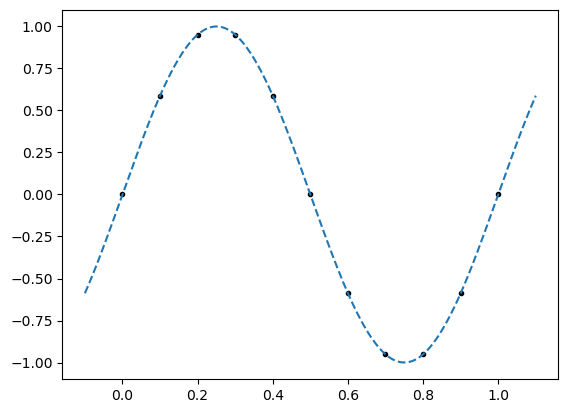

In [5]:
def get_cubic_spline(x, y):
    '''
    Solve for the interpolating cubic spline for a set of points.
    '''
    # setuo
    n = len(x)
    if (np.diff(x) < 0).any():  # we interpolate between neaby points, needs to be sorted
        idxs = np.argsort(x)
        x = x[idxs]
        y = y[idxs]
    assert (x[:-1] != x[1:]).all()

    ## build constraint matrix. In each concat the:
    # first row enforces P_i(x_i) = y_i
    # second row enforces P_i(x_{i+1}) = y_{i+1}
    # third row enforces P_i'(x_{i+1}) = P_{i+1}'(x_{i+1})
    # fourth row enforces P_i''(x_{i+1}) = P_{i+1}''(x_{i+1})
    data = np.concatenate([
            np.ravel([x[:-1]**3, x[:-1]**2, x[:-1], np.ones(n-1)], 'F'),
            np.ravel([x[1:]**3, x[1:]**2, x[1:], np.ones(n-1)], 'F'),
            np.ravel([3*x[1:-1]**2, 2*x[1:-1], np.ones(n-2), -3*x[1:-1]**2, -2*x[1:-1], -np.ones(n-2)], 'F'),
            np.ravel([3*x[:-1], np.ones(n-1), -3*x[1:], -np.ones(n-1)], 'F'),
        ])
    row = np.concatenate([
            np.repeat(np.arange(n-1), 4),
            n-1 + np.repeat(np.arange(n-1), 4),
            2*(n-1) + np.repeat(np.arange(n-2), 6),
            3*(n-1)-1 + np.repeat(np.arange(n), 4)[2:-2],
        ])
    col = np.concatenate([
            np.arange(4*(n-1)),
            np.arange(4*(n-1)),
            np.tile(np.arange(4*(n-1)).reshape(4, -1, order='F')[:3], (2, 1)).ravel('F')[3:-3],  # goes 0, 1 2, 4, 5, 6, 4, 5, 6... skipping the first and last three
            np.tile(np.arange(4*(n-1)).reshape(4, -1, order='F')[:2], (2, 1)).ravel('F')
        ])
    A = sparse.csr_array((data, (row, col)), shape=(4*(n-1), 4*(n-1)))
    b = np.concatenate([y[:-1], y[1:], np.zeros(2*(n-1))])

    # solve
    sol = sparse.linalg.spsolve(A, b)
    a = sol[::4]  # cubic mulitplier
    b = sol[1::4]  # quadratic mulitplier
    c = sol[2::4]  # linear multipler
    d = sol[3::4]  # intercept

    # create interpolating function and return
    def cubic_spline(X):
        '''
        The function representing the interpolating cubic spline at an X
        '''
        idx = np.minimum(np.maximum(np.searchsorted(x, X, 'right')-1, 0), n-2)  # figure out which spline to use to connect the points

        return a[idx]*X**3 + b[idx]*X**2 + c[idx]*X + d[idx]
    
    return cubic_spline

# grid we want to calculate values at
xrange = X_MAX - X_MIN
x_grid = np.linspace(X_MIN-xrange*0.1, X_MAX+xrange*0.1, 1001)

# plot it
plt.plot(X, Y, 'k.')
plt.plot(x_grid, get_cubic_spline(X, Y)(x_grid), '--')

#### Arbitrary Spline
Finally, we'll can also create a function that first an arbitrary degree $p$ spline to data. This is a little gross so don't try to understand how it works.

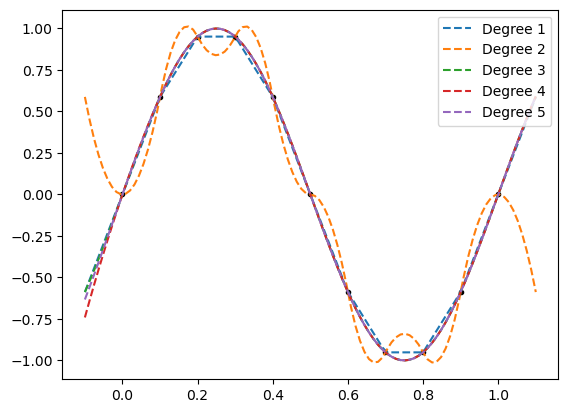

In [6]:
def get_spline(x, y, p):
    '''
    Solve for the interpolating degree p spline for a set of points.
    '''
    # setuo
    n = len(x)
    if (np.diff(x) < 0).any():  # we interpolate between neaby points, needs to be sorted
        idxs = np.argsort(x)
        x = x[idxs]
        y = y[idxs]
    assert (x[:-1] != x[1:]).all()

    # first part of constraint matrix: P_i(x_i) = y_i and P_i(x_{i+1}) = y_{i+1}
    data = [
            np.ravel([x[:-1]**i for i in range(p+1)[::-1]], 'F'),  # create array that goes x_1, 1, x_2, 1, ...
            np.ravel([x[1:]**i for i in range(p+1)[::-1]], 'F'),  # create array that goes x_2, 1, x_3, 1, ...
        ]
    row = [
            np.repeat(np.arange(n-1), (p+1)),
            n-1 + np.repeat(np.arange(n-1), (p+1)),
        ]
    col = [
            np.arange((p+1)*(n-1)),
            np.arange((p+1)*(n-1)),
        ]
    
    # derivative conditions: P_i'(x_{i+1}) = P_{i+1}'(x_{i+1})
    mult = 1+np.arange(p)  # polynomial multiplier for the derivative
    for d in range(1, p):
        # setup derivative
        s = None if d == p-1 else p+1-d  # enforce p-1th derivative at x_0 is 0
        e = None if d > 1 else d-p-1  # enfore d>1th derivative at x_n+1 is 0
        curr_row = (d+1)*(n-1) - (d>1) - (d<p-1)
        # (d-1)*n is number of rows added by derivatives
        # 2n is number of rows added since it fits the data
        # if d > 1, we insert an extra row since the 1st order derivate doesn't have 0 conditions
        # if d < p-1 we insert an extra row since the deriv_row starts at 1, not 0

        # get info
        data.append(
                np.ravel([mult[i]*x[:-1]**i for i in range(p+1-d)[::-1]] + [-mult[i]*x[1:]**i for i in range(p+1-d)[::-1]], 'F')[s:e]
            )
        row.append(curr_row + np.repeat(np.arange(n), 2*(p+1-d))[p+1-d:d-p-1][s:e])
        col.append(np.tile(np.arange((p+1)*(n-1)).reshape((p+1), -1, order='F')[:-d], (2, 1)).ravel('F')[s:e])

        # calculate multipler for the next round
        mult = mult[:-1] * mult[1:] // mult[1]

    # build constraint matrix
    data = np.concatenate(data)
    row = np.concatenate(row)
    col = np.concatenate(col)
    A = sparse.csr_array((data, (row, col)), shape=((p+1)*(n-1), (p+1)*(n-1)))
    b = np.concatenate([y[:-1], y[1:], np.zeros((p-1)*(n-1))])

    # get solution
    sol = sparse.linalg.spsolve(A, b)
    coeffs = [sol[i::(p+1)] for i in range(p+1)]

    # create interpolating function and return
    def spline(X):
        '''
        The function representing the interpolating cubic spline at an X
        '''
        idx = np.minimum(np.maximum(np.searchsorted(x, X, 'right')-1, 0), n-2)  # figure out which spline to use to connect the points

        return np.sum([coeffs[i][idx]*X**(p-i) for i in range(p+1)], axis=0)
    
    return spline

# grid we want to calculate values at
xrange = X_MAX - X_MIN
x_grid = np.linspace(X_MIN-xrange*0.1, X_MAX+xrange*0.1, 101)

# plot it
plt.plot(X, Y, 'k.')
for p in range(1, 6):
    plt.plot(x_grid, get_spline(X, Y, p)(x_grid), '--', label=f'Degree {p}')
plt.legend()